In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch_geometric
from torch_geometric.nn import MetaLayer
from torch_scatter import scatter_add
from torch_sparse import coalesce

import matplotlib.pyplot as plt


In [2]:

def dummy_graph(n_nodes, node_dim, edge_dim):    
    # Connect every node together
    edge_index = torch.tensor([[i, j] for i in range(0, n_nodes) 
                               for j in range(i+1, n_nodes)]).t()
    n_edges = edge_index.shape[1]
    # Generate node and edge features
    x = torch.randn(n_nodes, node_dim)
    e = torch.randn(n_edges, edge_dim)
    # Construct the graph
    return torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=e)

class DummyDataset(Dataset):
    
    def __init__(self, n_samples, n_nodes, node_dim, edge_dim):
        super(DummyDataset, self).__init__()
        self.graphs = [dummy_graph(n_nodes, node_dim, edge_dim) for i in range(n_samples)]
    
    def __getitem__(self, index):
        return self.graphs[index]
    
    def __len__(self):
        return len(self.graphs)

def draw_graph(data):
    plt.figure()
    plt.scatter(data.x[:,0], data.x[:,1])
    for start, end in zip(*data.edge_index):
        plt.plot([data.x[start, 0], data.x[end, 0]],
                 [data.x[start, 1], data.x[end, 1]])
        
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()        

In [3]:
# Dummy data config
n_nodes = 10
node_dim = 2
edge_dim = 3

In [4]:
data = dummy_graph(n_nodes, node_dim, edge_dim)
data

Data(edge_attr=[45, 3], edge_index=[2, 45], x=[10, 2])

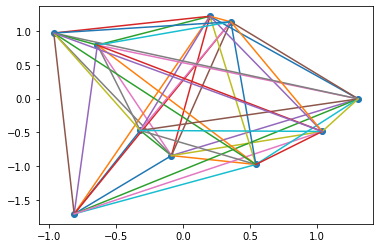

In [5]:
draw_graph(data)

In [7]:
data

Data(edge_attr=[45, 3], edge_index=[2, 45], x=[10, 2])

In [12]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
G.edges
#visualize(G, color=data.y)

EdgeView([])

In [13]:
class NodeModel(nn.Module):
    def __init__(self, node_dim, edge_dim, num_hidden):
        super(Edge, self).__init__()
        # message passing
        self.model = nn.Sequential(
            nn.Linear(node_dim+edge_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, edge_dim),
            nn.ReLU()
        )
    def forward(self, x_sender, x_receiver, e, batch=None):
        inputs = torch.cat([x_sender, x_receiver, e], 1)
        return self.model(inputs)   

class EdgeModel(nn.Module):
    """A simple node module"""
    
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(NodeModule, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(edge_dim + node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim),
            nn.ReLU()
        )

    def forward(self, x, edge_index, e, batch=None):
        # Sum edge features at each receiver
        senders, receivers = edge_index
        aggr = scatter_add(e, receivers, dim=0)
        inputs = torch.cat([x, aggr], 1)
        return self.network(inputs)

class GraphNeuralNewtwork(nn.Module):
    """A simple graph network"""
    
    def __init__(self, input_node_dim, input_edge_dim,
                 hidden_node_dim, hidden_edge_dim, 
                 n_graph_iters=1):
        super(GNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.node_encoder
        # Meta layer take a graph as input and returns and updated graph as output
        self.graph_layer = MetaLayer(
            edge_model=EdgeModule(input_node_dim, input_edge_dim, hidden_edge_dim),
            node_model=NodeModule(input_node_dim, input_edge_dim, hidden_node_dim)
        )
        
    def forward(self, data):
        return self.graph_layer(data.x, data.edge_index, data.edge_attr)

In [14]:
class GNN(nn.Module):
    """A simple graph network"""
    
    def __init__(self, input_node_dim, input_edge_dim,
                 hidden_node_dim, hidden_edge_dim, 
                 n_graph_iters=1):
        super(GNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        
        # The node encoder transforms input node features to the hidden space
        self.node_encoder = nn.Sequential(
            nn.Linear(input_node_dim, hidden_node_dim),
            nn.ReLU()
        )
        # Similarly, the edge encoder transforms input edge features to hidden space
        self.edge_encoder = nn.Sequential(
            nn.Linear(input_edge_dim, hidden_edge_dim),
            nn.ReLU()
        )
        # The edge network computes new edge features
        self.edge_network = nn.Sequential(
            nn.Linear(2*hidden_node_dim + hidden_edge_dim, hidden_edge_dim),
            nn.ReLU(),
            nn.Linear(hidden_edge_dim, hidden_edge_dim),
            nn.ReLU()
        )
        # The node network computes new node features
        self.node_network = nn.Sequential(
            nn.Linear(hidden_node_dim + hidden_edge_dim, hidden_node_dim),
            nn.ReLU(),
            nn.Linear(hidden_node_dim, hidden_node_dim),
            nn.ReLU()
        )
        # The edge classifier computes final edge scores
        self.edge_classifier = nn.Sequential(
            nn.Linear(2*hidden_node_dim + hidden_edge_dim, hidden_edge_dim),
            nn.ReLU(),
            nn.Linear(hidden_edge_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)
        e = self.edge_encoder(data.edge_attr)
        e = torch.cat([e, e], dim=0) # bi-directional

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx], e], 1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_inputs = scatter_add(e, recv_idx, dim=0)

            # Compute new node features
            node_inputs = torch.cat([x, aggr_inputs], 1)
            x = self.node_network(node_inputs)

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        e = e[:start_idx.shape[0]]
        clf_inputs = torch.cat([x[start_idx], x[end_idx], e], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

In [16]:

import os
from collections import namedtuple

import numpy as np
from torch_geometric.data import Batch

def load_graph(filename):
    with np.load(filename) as f:
        x, y = f['X'], f['y']
        Ri_rows, Ri_cols = f['Ri_rows'], f['Ri_cols']
        Ro_rows, Ro_cols = f['Ro_rows'], f['Ro_cols']
        n_edges = Ri_cols.shape[0]
        edge_index = np.zeros((2, n_edges), dtype=int)
        edge_index[0, Ro_cols] = Ro_rows
        edge_index[1, Ri_cols] = Ri_rows
    return x, edge_index, y

class HitGraphDataset(Dataset):
    """PyTorch dataset specification for hit graphs"""

    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = filenames if n_samples is None else filenames[:n_samples]

    def __getitem__(self, index):
        x, edge_index, y = load_graph(self.filenames[index])
        return torch_geometric.data.Data(x=torch.from_numpy(x),
                                         edge_index=torch.from_numpy(edge_index),
                                         y=torch.from_numpy(y))

    def __len__(self):
        return len(self.filenames)

In [17]:
# Data config
n_samples = 1024
batch_size = 2

data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/data/hitgraphs_small_000'

In [ ]:
dataset = HitGraphDataset(input_dir=data_dir, n_samples=n_samples)